In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import random
import string
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool1D

In [2]:
with open('/content/KB_translated.json', 'r') as f:
    data = json.load(f)  # Membaca data dari file JSON dan menyimpannya dalam variabel 'data'

df = pd.DataFrame(data['intents'])  # Membuat DataFrame dari bagian 'intents' dalam data JSON

In [3]:
nltk.download('punkt')  # Menginstall paket punkt yang diperlukan oleh NLTK
nltk.download('punkt_tab')
nltk.download('wordnet')  # Menginstall paket wordnet yang diperlukan oleh NLTK
nltk.download('omw-1.4')  # Menginstall paket omw-1.4 yang diperlukan oleh NLT

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
print(data['intents'][0])

{'tag': 'salam', 'patterns': ['Hai', 'Apakah ada orang disana?', 'Hai, yang di sana', 'Halo', 'Hai semuanya', 'Ola'], 'responses': ['Halo. Ceritakan bagaimana perasaanmu hari ini?', 'Hai. Apa yang membawamu ke sini hari ini?', 'Hai. Apa kabar hari ini?', 'Senang bertemu Anda. Bagaimana perasaan Anda saat ini?', 'Halo. Senang melihat Anda kembali. Apa yang sedang terjadi di dunia Anda saat ini?', 'Halo! Apa yang sedang Anda pikirkan?', 'Halo! Ada yang bisa saya bantu hari ini?', 'Halo! Apa yang bisa saya bantu?', 'Ola! Apa kabar?', 'Hai! Apa kabar?', 'Apakah ada orang di sana? Bagaimana saya bisa membantu Anda?', 'Hai. Apa kabar?', 'Halo! Bagaimana saya dapat mendukung Anda hari ini?', 'Hai! Apa kabar hari ini?', 'Halo! Apa yang bisa saya bantu?', 'Hai! Apa yang membawamu ke sini hari ini?', 'Halo! Ada yang bisa saya bantu?']}


In [ ]:
for i, intent in enumerate(data['intents']):
       try:
           responses[intent['tag']] = intent['responses']
       except KeyError:
           print(f"Error pada intent index {i}: {intent}")

NameError: name 'responses' is not defined

In [6]:
tags = []
inputs = []
responses = {}
words = []
classes = []
documents = []
ignore_words = ['?', '!']

for intent in data['intents']:
    responses[intent['tag']] = intent['responses']
    for lines in intent['patterns']:
        inputs.append(lines)
        tags.append(intent['tag'])
        for pattern in intent['patterns']:
          w = nltk.word_tokenize(pattern)
          words.extend(w)
          documents.append((w, intent['tag']))
          if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [ ]:
!pip install googletrans==4.0.0-rc1

In [ ]:
!pip install deep_translator

import json
from deep_translator import GoogleTranslator

def translate_json(data, target_language='id'):
    """
    Menerjemahkan isi file JSON ke bahasa target.

    Args:
        data: Dictionary yang berisi data JSON.
        target_language: Kode bahasa target (misalnya, 'id' untuk bahasa Indonesia).

    Returns:
        Dictionary yang berisi data JSON yang telah diterjemahkan.
    """
    translator = GoogleTranslator(source='auto', target=target_language)
    translated_data = {}

    for key, value in data.items():
        if isinstance(value, str):
            try:
                translated_data[key] = translator.translate(value)
            except Exception as e:
                print(f"Error menerjemahkan '{value}': {e}")
                translated_data[key] = value  # Gunakan nilai asli jika terjadi error
        elif isinstance(value, list):
            translated_data[key] = [
                translate_json(item, target_language) if isinstance(item, dict) else
                translator.translate(item) if isinstance(item, str) else
                item
                for item in value
            ]
        elif isinstance(value, dict):
            translated_data[key] = translate_json(value, target_language)
        else:
            translated_data[key] = value

    return translated_data

# Load data JSON
with open('/content/KB.json', 'r') as f:
    data = json.load(f)

# Translate data JSON ke bahasa Indonesia
translated_data = translate_json(data, target_language='id')

# Simpan data JSON yang telah diterjemahkan
with open('/content/KB_translated.json', 'w', encoding='utf-8') as f:
    json.dump(translated_data, f, indent=2, ensure_ascii=False)

print("File JSON telah diterjemahkan dan disimpan sebagai KB_translated.json")

File JSON telah diterjemahkan dan disimpan sebagai KB_translated.json


In [7]:
#split dataset
x_train, x_test, y_train, y_test = train_test_split(inputs, tags, test_size = 0.25, random_state = 42)

#konversi data ke dalam dataframe
train_data = pd.DataFrame({'patterns': x_train, 'tags': y_train})
test_data = pd.DataFrame({'patterns': x_test, 'tags': y_test})

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3825 entries, 0 to 3824
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  3825 non-null   object
 1   tags      3825 non-null   object
dtypes: object(2)
memory usage: 59.9+ KB


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1276 entries, 0 to 1275
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  1276 non-null   object
 1   tags      1276 non-null   object
dtypes: object(2)
memory usage: 20.1+ KB


In [10]:
train_data.describe()

,patterns,tags
count,3825,3825
unique,2125,75
top,Aku tidak cukup baik untuk membuat siapa pun p...,tidak berguna
freq,54,818


In [11]:
test_data.describe()

,patterns,tags
count,1276,1276
unique,851,52
top,Aku merasa aku gagal dalam segala hal yang kul...,tidak berguna
freq,20,289


In [12]:
train_data.head()

,patterns,tags
0,Berbicara denganmu tidak membantuku mengurangi...,memahami
1,"Saya penasaran tentang meditasi, tetapi saya t...",meditasi
2,Aku tidak cukup baik untuk membuat siapa pun p...,tidak berguna
3,Aku merasa seperti kehilangan akal karena tida...,tidur
4,Aku tidak berharga dan tidak layak untuk dicin...,tidak berguna


In [13]:
test_data.head()

,patterns,tags
0,Aku merasa seperti aku selalu berada di tepi j...,stres
1,Kamu tidak bisa diandalkan,benci kamu
2,Aku merasa aku hanya menjadi beban bagi masyar...,tidak berguna
3,Bukan itu yang ingin aku katakan,salah
4,"Baiklah, kita lupakan saja topik itu.",tidak berbicara


In [14]:
train_data['patterns'] = train_data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
train_data['patterns'] = train_data['patterns'].apply(lambda wrd: ''.join(wrd))
test_data['patterns'] = test_data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
test_data['patterns'] = test_data['patterns'].apply(lambda wrd: ''.join(wrd))

In [15]:
#inisialisasi lemamatizer
lemmatizer = WordNetLemmatizer()

#fungsi untuk melakukan lemmatization pada kata_kata dalam kalimat
def lemmatize_text(text):
  tokens = nltk.word_tokenize(text) #tokenisasi kata_kata dalam kalimat
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens] #lemmatization kata_kata dalam kalimat
  lemmatized_text = ' '.join(lemmatized_tokens) #menggabungkan kembali kata_kata menjadi kalimat
  return lemmatized_text

#contoh penggunaan fungsi lemmatize_text pada dataset
train_data['patterns'] = train_data['patterns'].apply(lemmatize_text)
test_data['patterns'] = test_data['patterns'].apply(lemmatize_text)

In [17]:
# tokenisasi data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['patterns'])

x_train = tokenizer.texts_to_sequences(train_data['patterns'])
x_test = tokenizer.texts_to_sequences(test_data['patterns'])

In [18]:
# apply padding
max_sequence_length = max(len(seq) for seq in x_train + x_test)
x_train = pad_sequences(x_train, maxlen=max_sequence_length)
x_test = pad_sequences(x_test, maxlen=max_sequence_length)

In [19]:
from operator import le
#combine tags from train_data and test_data
all_tags = list(set(train_data['tags']) | set(test_data['tags']))

#encoding the outputs
le = LabelEncoder()
le.fit(all_tags)

y_train = le.transform(train_data['tags'])
y_test = le.transform(test_data['tags'])

In [20]:
#splitting the dataset
train_dataset = (x_train, y_train)
test_dataset = (x_test, y_test)

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))

In [22]:
from sre_constants import GROUPREF_UNI_IGNORE
from itertools import dropwhile
#creating the model
#menambahkan regularisasi L2
regularization = regularizers.l2(0.01)

#mengubah tingkat dropout
dropout_rate = 0.5

#mendefinisikan input layer
i = Input(shape=(max_sequence_length,))

#embedding layer
embedding_size = 100
x = Embedding(len(tokenizer.word_index) + 1, embedding_size)(i)

#bidirectional LSTM layer
lstm_units = 32
x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)

#bidirectional GRU layer
gru_units = 64
x = Bidirectional(GRU(gru_units, return_sequences=True))(x)

#flatten layer
x = Flatten()(x)

#dense layer with L2 regularization
dense_units = 50
x = Dense(dense_units, activation='relu', kernel_regularizer=regularization)(x)

#dropout layer
x = Dropout(dropout_rate)(x)

#output layer
num_classes = len(le.classes_)
x = Dense(num_classes, activation="softmax")(x)

#membuat model
model = Model(i, x)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 29)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 29, 100)             │         157,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 29, 64)              │          34,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 29, 128)             │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3712)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │         185,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 79)                  │           4,029 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 430,647 (1.64 MB)

 Trainable params: 430,647 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
class myCallback(tf.keras.callbacks.Callback):
  #define the method that check the accuracy at the end of each epoch
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy')> 0.80:
      print("\nReached 0.7 val acc so cancelling training!")

      #stop training once the above conditional is met
      self.model.stop_training = True

In [24]:
#instantiate the callback class
cb = myCallback()

In [25]:
learning_rate = 0.0005

In [26]:
optimizer = Adam(learning_rate=learning_rate)

In [27]:
#compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [28]:
#training the model
history = model.fit(train_dataset[0], train_dataset[1], batch_size=10, epochs=700, callbacks=[cb], validation_data=test_dataset)

Epoch 1/700
383/383 ━━━━━━━━━━━━━━━━━━━━ 43s 84ms/step - accuracy: 0.2209 - loss: 3.7604 - val_accuracy: 0.5094 - val_loss: 1.9820
Epoch 2/700
383/383 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - accuracy: 0.5022 - loss: 2.0616 - val_accuracy: 0.5886 - val_loss: 1.6835
Epoch 3/700
383/383 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.5824 - loss: 1.6643 - val_accuracy: 0.6129 - val_loss: 1.5260
Epoch 4/700
383/383 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - accuracy: 0.6059 - loss: 1.4739 - val_accuracy: 0.6630 - val_loss: 1.3931
Epoch 5/700
383/383 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - accuracy: 0.6277 - loss: 1.3902 - val_accuracy: 0.6850 - val_loss: 1.2655
Epoch 6/700
383/383 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step - accuracy: 0.7008 - loss: 1.1770 - val_accuracy: 0.7139 - val_loss: 1.2300
Epoch 7/700
383/383 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.7340 - loss: 1.0705 - val_accuracy: 0.7124 - val_loss: 1.2401
Epoch 8/700
383/383 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - accuracy: 0.7592 - loss: 0

In [ ]:
#save model h5
model.save('model.h5')

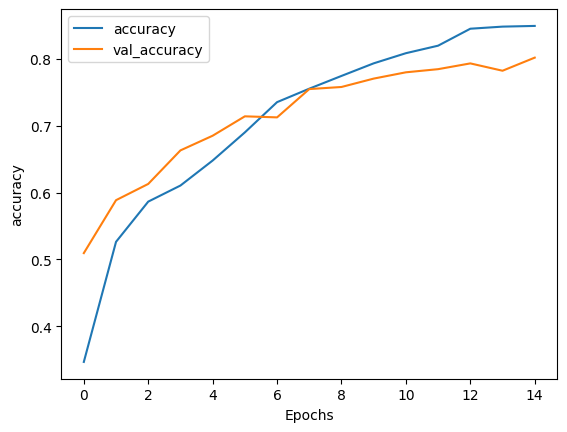

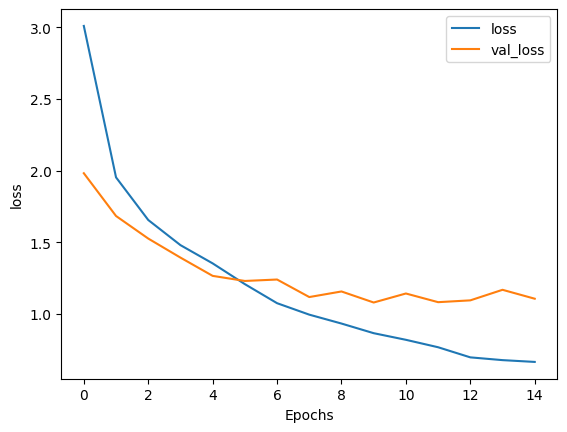

In [29]:
#diisi dengan plot hasil accuracy dan loss training dan testing

#plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

  #plot the accuracy
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [30]:
#Menyimpan model setelah pelatihan
model.save('my_model.keras')

In [ ]:
#Hiperparameter	Rekomendasi	Alasan
#dropout rate	0.5	Nilai umum yang digunakan untuk mencegah overfitting.
#embedding size	128	Ukuran umum yang memberikan representasi kata yang baik.
#GRU unit	64	Jumlah unit yang cukup untuk menangkap informasi sekuensial.
#LSTM unit	32	Jumlah unit yang cukup untuk menangkap informasi sekuensial.
#dense unit	64	Jumlah unit yang cukup untuk lapisan tersembunyi.
#batch size	32	Nilai yang direkomendasikan berdasarkan ukuran dataset Anda.
#epoch	100	Jumlah epoch yang cukup untuk konvergensi model.
#learning rate	0.001	Nilai umum yang digunakan untuk Adam optimizer.


In [ ]:
#membuat input chat
while True:
  texts_p = []
  prediction_input = input('You: ')

  #menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenize dan padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input], max_sequence_length)

  #membuat prediksi menggunakan model
  output = model.predict(prediction_input)
  output = output.argmax()

  #menemukan respon sesuai data tag
  response_tag = le.inverse_transform([output])[0]
  print("ChatBot: ", random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

You: hai
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
ChatBot:  Saya di sini untuk membantu. Silakan terus berbagi.
You: Apakah ada orang disana?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
ChatBot:  Kedengarannya seperti rencana!
You: Ceritakan tentang dirimu padaku
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
ChatBot:  Tentu saja, aspek kesehatan mental spesifik apa yang Anda minati?
You: aku sedang merasa kesepian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
ChatBot:  Saya mengerti Anda. Bisakah Anda berbagi lebih banyak tentang apa yang mengganggu Anda?
You: Saya cemas dan sulit merasakan apa pun kecuali kewalahan.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
ChatBot:  Saya tahu kecemasan dapat membuat segalanya terasa berat. Apa yang paling mengganggu Anda?
You: goodbye
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
ChatBot:  Saya siap mendengarkan. Silakan terus berbagi.


KeyboardInterrupt: Interrupted by user

In [ ]:
#save model h5
#model.save('model.h5')

In [ ]:
#save model h5
model.save('/content/gdrive/My Drive/model.h5')

In [ ]:
import json
import pandas as pd

# Muat dataset
with open('KB_translated.json', 'r') as f:
    data = json.load(f)

# Ubah data JSON ke DataFrame
df = pd.DataFrame(data['intents'])

# Fungsi untuk mengonversi semua elemen menjadi hashable
def deep_tuple(x):
    if isinstance(x, list):
        return tuple(map(deep_tuple, x))
    elif isinstance(x, dict):
        return tuple(sorted((k, deep_tuple(v)) for k, v in x.items()))
    else:
        try:
            return hash(x)  # Coba hash jika memungkinkan
        except TypeError:
            return str(x)  # Konversi ke string jika tidak bisa di-hash

# Terapkan fungsi deep_tuple ke semua kolom
for col in df.columns:
    df[col] = df[col].apply(deep_tuple)

# Hapus duplikasi
df.drop_duplicates(inplace=True)

# ... (Kode untuk konversi kembali dan menyimpan data) ...

In [ ]:
import json
import pandas as pd

# --- Fungsi untuk konversi data ---
def deep_tuple(x):
    if isinstance(x, list):
        return tuple(map(deep_tuple, x))
    elif isinstance(x, dict):
        return tuple(sorted((k, deep_tuple(v)) for k, v in x.items()))
    else:
        try:
            return hash(x)
        except TypeError:
            return str(x)

def deep_list(x):
    if isinstance(x, tuple):
        return list(map(deep_list, x))
    return x
# --- Akhir fungsi konversi ---

# Muat dataset
with open('KB_translated.json', 'r') as f:  # Ganti 'nama_file.json' dengan nama file Anda
    data = json.load(f)

# Ubah data JSON ke DataFrame
df = pd.DataFrame(data['intents'])

# Terapkan deep_tuple ke semua kolom untuk konversi
for col in df.columns:
    df[col] = df[col].apply(deep_tuple)

# Hapus duplikasi
df.drop_duplicates(inplace=True)

# Terapkan deep_list ke semua kolom untuk konversi kembali
for col in df.columns:
    df[col] = df[col].apply(deep_list)

# Ubah DataFrame kembali ke data JSON
data['intents'] = df.to_dict('records')

# Simpan dataset yang telah diubah
with open('KB_translated_tanpa_duplikat.json', 'w') as f:  # Ganti 'nama_file_tanpa_duplikat.json' dengan nama file yang diinginkan
    json.dump(data, f, indent=4)

print("Dataset telah diproses dan disimpan sebagai KB_translated_tanpa_duplikat.json")

Dataset telah diproses dan disimpan sebagai KB_translated_tanpa_duplikat.json
